# TUTORIAL: ¿CÓMO MEDIR LA CALIDAD DE LOS PRONÓSTICOS EN SERIES DE TIEMPO?

En este tutorial vamos a ver cuáles son las métricas más usadas para medir la calidad de los pronósticos generados por un modelo predictivo en Series de Tiempo. Además veremos los pros y los contras de cada una de estas métricas y las sugerencias de uso

Contenido:
1. ¿Qué es la calidad de los pronósticos y para qué cuantificarla?
2. Las métricas de desempeño más usadas: RMSE, MAE y MAPE
3. ¿Cómo usar las métricas para medir el desempeño de un modelo?

## 1. ¿Qué es la calidad de los pronósticos y para qué cuantificarla?

- Cuando construimos un modelo predictivo para Series de Tiempo lo que nos interesa es saber qué tan buenos o qué tan malos son los pronósticos que genera
- Así que la idea es **cuantificar** de alguna manera el error en los pronósticos
- Si cuantificamos este error en los pronósticos podremos decidir:
    - Si el modelo que estamos implementando es adecuado
    - O si probamos varios modelos cuál de ellos será el más adecuado


Entendamos la idea básica de esta medición de desempeño. Comencemos leyendo el set de datos que contiene el registro histórico (diario) del comportamiento del valor de la acción de Apple durante los últimos años:

In [7]:
# Leer dataset y limpiar

import pandas as pd
import numpy as np

# Cargar dataset crudo
df = pd.read_csv('accion_apple_21-25.csv')

# Convertir columna Fecha a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y')

# Limpiar columnas numéricas (coma -> punto decimal, eliminar separadores de miles)
for col in ['Último','Apertura','Máximo','Mínimo']:
    df[col] = (df[col]
               .astype(str)
               .str.replace('.', '', regex=False)
               .str.replace(',', '.', regex=False)
               .astype(float))

# Limpiar volumen
df['Vol.'] = (df['Vol.']
              .astype(str)
              .str.replace('M','', regex=False)
              .str.replace('.', '', regex=False)
              .str.replace(',', '.', regex=False)
              .astype(float) * 1_000_000)

# Limpiar % var.
df['% var.'] = (df['% var.']
                .astype(str)
                .str.replace('%','', regex=False)
                .str.replace('.', '', regex=False)
                .str.replace(',', '.', regex=False)
                .astype(float))

# Renombrar columnas a formato estándar
df = df.rename(columns={
    'Fecha': 'ds',
    'Último': 'y',
    'Apertura': 'Open',
    'Máximo': 'High',
    'Mínimo': 'Low',
    'Vol.': 'Volume',
    '% var.': 'Change'
})

# Ordenar por fecha
df = df.sort_values('ds').reset_index(drop=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1191 non-null   datetime64[ns]
 1   y       1191 non-null   float64       
 2   Open    1191 non-null   float64       
 3   High    1191 non-null   float64       
 4   Low     1191 non-null   float64       
 5   Volume  1191 non-null   float64       
 6   Change  1191 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 65.3 KB
None
          ds       y    Open    High     Low       Volume  Change
0 2021-01-04  129.41  133.52  133.61  126.76  143300000.0   -2.47
1 2021-01-05  131.01  128.89  131.74  128.43   97660000.0    1.24
2 2021-01-06  126.60  127.72  131.05  126.38  155090000.0   -3.37
3 2021-01-07  130.92  128.36  131.63  127.86  109580000.0    3.41
4 2021-01-08  132.05  132.43  132.63  130.23  105160000.0    0.86


In [8]:
# Split train/test

train = df.iloc[:-365]   # todo menos el último año
test  = df.iloc[-365:]   # último año como prueba
test

,ds,y,Open,High,Low,Volume,Change
826,2024-04-17,168.00,169.61,170.65,168.00,50900000.0,-0.81
827,2024-04-18,167.04,168.03,168.64,166.55,43120000.0,-0.57
828,2024-04-19,165.00,166.21,166.40,164.07,68150000.0,-1.22
829,2024-04-22,165.84,165.51,167.26,164.77,48120000.0,0.51
830,2024-04-23,166.90,165.35,167.05,164.92,49540000.0,0.64
...,...,...,...,...,...,...,...
1186,2025-09-24,252.31,255.22,255.74,251.04,42300000.0,-0.83
1187,2025-09-25,256.87,253.21,257.17,251.71,55200000.0,1.81
1188,2025-09-26,255.46,254.10,257.60,253.78,46080000.0,-0.55
1189,2025-09-29,254.43,254.56,255.00,253.01,40130000.0,-0.40


In [9]:
!pip install prophet

In [10]:

# =========================================
# 3) Prophet (solo TRAIN para evaluar en TEST)
# =========================================
from prophet import Prophet
m = Prophet()
m.fit(train.rename(columns={"ds": "ds", "y": "y"}))



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzqkh9_m/9cgcwnd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzqkh9_m/_yk07ffj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6005', 'data', 'file=/tmp/tmpxzqkh9_m/9cgcwnd3.json', 'init=/tmp/tmpxzqkh9_m/_yk07ffj.json', 'output', 'file=/tmp/tmpxzqkh9_m/prophet_modelyhnx8bqh/prophet_model-20251001134122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# Construir futuro exactamente con las fechas de TEST
future_test = pd.DataFrame({"ds": test["ds"]})

# Generar predicción SOLO en esas fechas
forecast_test = m.predict(future_test)

# Vector de predicciones alineado a TEST
y_pred = forecast_test["yhat"]
y_pred

,yhat
0,174.154154
1,173.897284
2,173.869827
3,173.300648
4,172.891428
...,...
360,147.039400
361,146.566516
362,146.372196
363,145.633127


In [12]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-04-17,175.912454,167.313567,180.671433,175.912454,175.912454,-1.758299,-1.758299,-1.758299,-1.069672,-1.069672,-1.069672,-0.688627,-0.688627,-0.688627,0.0,0.0,0.0,174.154154
1,2024-04-18,175.871357,166.831519,180.564542,175.871357,175.871357,-1.974073,-1.974073,-1.974073,-1.173536,-1.173536,-1.173536,-0.800537,-0.800537,-0.800537,0.0,0.0,0.0,173.897284
2,2024-04-19,175.830260,167.079827,180.973732,175.830260,175.830260,-1.960433,-1.960433,-1.960433,-1.029916,-1.029916,-1.029916,-0.930517,-0.930517,-0.930517,0.0,0.0,0.0,173.869827
3,2024-04-22,175.706970,166.427553,179.582826,175.706970,175.706970,-2.406322,-2.406322,-2.406322,-0.959732,-0.959732,-0.959732,-1.446590,-1.446590,-1.446590,0.0,0.0,0.0,173.300648
4,2024-04-23,175.665874,166.021848,179.082636,175.665874,175.665874,-2.774445,-2.774445,-2.774445,-1.108588,-1.108588,-1.108588,-1.665857,-1.665857,-1.665857,0.0,0.0,0.0,172.891428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2025-09-24,154.336668,19.955138,270.616319,30.110932,277.981047,-7.297268,-7.297268,-7.297268,-1.069672,-1.069672,-1.069672,-6.227596,-6.227596,-6.227596,0.0,0.0,0.0,147.039400
361,2025-09-25,154.295571,21.863725,271.686194,29.654384,278.773515,-7.729055,-7.729055,-7.729055,-1.173536,-1.173536,-1.173536,-6.555518,-6.555518,-6.555518,0.0,0.0,0.0,146.566516
362,2025-09-26,154.254474,22.002366,270.971281,29.197836,279.416153,-7.882278,-7.882278,-7.882278,-1.029916,-1.029916,-1.029916,-6.852361,-6.852361,-6.852361,0.0,0.0,0.0,146.372196
363,2025-09-29,154.131184,17.879621,270.607881,28.657262,279.948077,-8.498057,-8.498057,-8.498057,-0.959732,-0.959732,-0.959732,-7.538325,-7.538325,-7.538325,0.0,0.0,0.0,145.633127


In [13]:
# Métricas en TEST
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

y_true = test["y"].values

mae  = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
print(f"Prophet | MAE={mae:.4f} | RMSE={rmse:.4f}")


Prophet | MAE=56.4833 | RMSE=59.4920


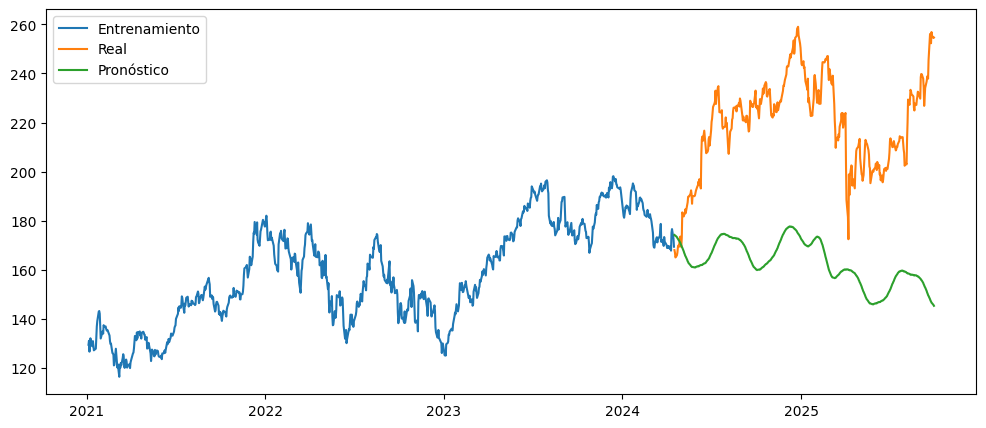

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train["ds"], train["y"], label="Entrenamiento")
plt.plot(test["ds"], test["y"], label="Real")
plt.plot(test["ds"], y_pred, label="Pronóstico")

plt.legend()
plt.show()


La columna y contiene los valores reales de la acción en el conjunto de prueba, mientras que el vector y_pred corresponde a los pronósticos generados por el modelo Prophet.
En el gráfico se observa la comparación entre los valores reales y los pronosticados.

Veamos gráficamente cómo se comparan los valores reales con los pronosticados:

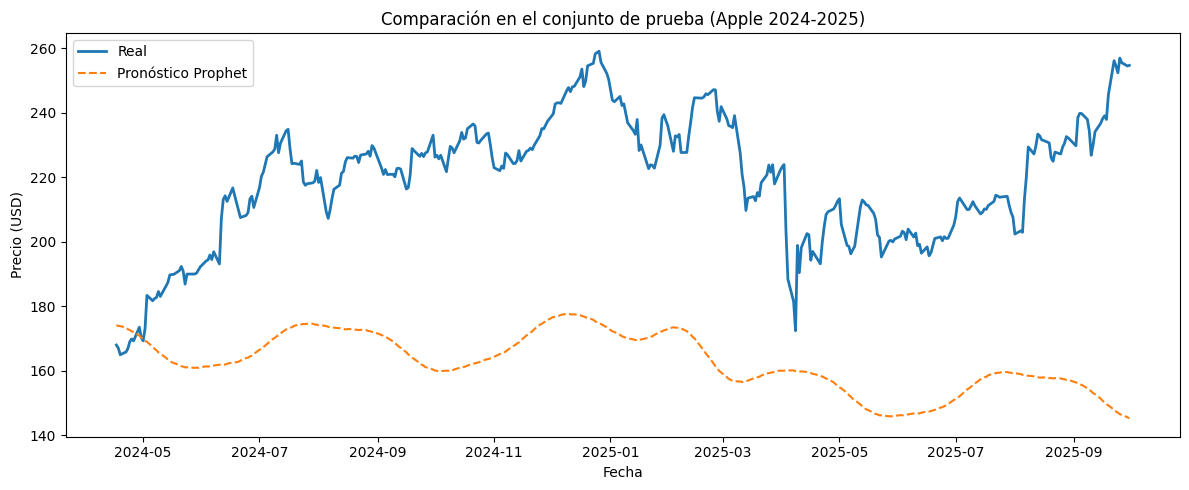

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test["ds"], test["y"], label="Real", linewidth=2)
plt.plot(test["ds"], y_pred, label="Pronóstico Prophet", linestyle="--")

plt.title("Comparación en el conjunto de prueba (Apple 2024-2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.tight_layout()
plt.show()


Vemos que:

- Los pronósticos siguen "bastante bien" el comportamiento de la Serie original
- Pero en algunos instantes de tiempo la predicción "no es tan buena" pues no logra capturar variaciones rápidas en la Serie original, lo cual incrementa el error en ciertos períodos.

La idea es que no seamos subjetivos al evaluar el desempeño del modelo y que usemos algunas métricas para cuantificar dicho desempeño.

## 2. Las métricas de desempeño más usadas: RMSE, MAE y MAPE

Aunque hay múltiples métricas, las más usadas son convencionalmente RMSE, MAE y MAPE.

Veamos en detalle cada una de estas métricas, así como su forma de cálculo y sus ventajas y desventajas.

### 2.1. Raíz cuadrada del error cuadrático medio (*RMSE: root mean squared error*)

Si $N$ es la cantidad de datos que tiene la Serie, $y_t$ es la observación (valor conocido) en cada instante de tiempo y $\hat{y}_t$ es el pronóstico correspondiente, entonces:

$$\text{RMSE} = \sqrt{\frac {\sum_{t=1}^{n} \left( y_t - \hat{y}_t \right)^2}{N}}$$

Algunas características, ventajas y desventajas de esta métrica:
- Es dependiente de la escala: **la métrica está en la misma escala de las observaciones originales**
- ✅ Es fácil de interpretar (precisamente porque está en la misma escala de los datos originales)
- ❌ Es sensible a valores extremos, pues el error cuadrático "amplifica" las diferencias (aunque esto puede ser visto como una ventaja)

Calculemos el RMSE para los pronósticos anteriores:

In [16]:
y=y_true
y_pred=y_pred

mse=np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} USD  (MSE: {mse:.2f} USD2)")

RMSE: 59.49 USD  (MSE: 3539.30 USD2)


¿Este valor corresponde a un desempeño adecuado o no?

Se debe comparar con el rango de valores de la Serie original:  
- Así, la Serie original tiene valores cercanos a los **225 USD** y el error que se tiene en el pronóstico es del orden de **59.5 USD (RMSE)**.  
- Y por tanto este error representa aproximadamente un **26%** de la escala original de la Serie.  

Preguntas que deberíamos responder:  
- ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?  
- ¿Existe algún modelo que genere un menor error?  

### 2.2. Error absoluto medio (*MAE: mean absolute error*)

En este caso el error se calcula como:

$$\text{MAE} = \frac{\sum_{t=1}^{n} | y_t - \hat{y}_t |}{N}$$

Algunas características, ventajas y desventajas de esta métrica:
- Es dependiente de la escala: **la métrica está en la misma escala de las observaciones originales**
- ✅ Es fácil de interpretar (precisamente porque está en la misma escala de los datos originales)
- ✅ Es menos sensible a valores extremos en comparación con el RMSE (aunque esto puede ser visto como una desventaja)
    - ❌ Puede indicar un desempeño más optimista que el obtenido con el RMSE

Calculemos el MAE para los pronósticos anteriores:

In [17]:
mae = np.mean(np.abs(y - y_pred))
print(f"MAE: {mae:.2f} USD")

MAE: 56.48 USD


Recordemos que el RMSE fue de 59.49 USD. Esto se debe a que esta métrica es más sensible a valores extremos, mientras que el MAE mide el error promedio absoluto.  

En este caso, los **56.48 USD** de MAE representan aproximadamente un **25%** de la escala original de la Serie (225 USD).  
De nuevo, debemos preguntarnos:

- ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?  
- ¿Existe algún modelo que genere un menor error?  

### 2.3. Error porcentual absoluto medio (*MAPE: mean absolute percentage error*)

En este caso el error se calcula como:

$$\text{MAPE} = \frac{100}{n} \sum_{t=1}^{n} \left| \frac{y_t - \hat{y}_t}{y_t} \right|$$


Algunas características, ventajas y desventajas de esta métrica:
- Es **independiente de la escala: la métrica se mide como un porcentaje
- ✅ Es fácil de interpretar: 0% → mejor desempeño, 100% o más → desempeño "terrible"
- ✅ Es menos sensible a valores extremos en comparación con el RMSE
- ❌ No es adecuada si la serie original contiene valores iguales o muy cercanos a cero

Calculemos el MAPE para los pronósticos anteriores:

In [18]:
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 25.27%


Lo cual quiere decir que, en promedio, el modelo genera pronósticos que se alejan en un **25.27%** del valor real de la Serie.

Al igual que en los casos anteriores, debemos preguntarnos:

- ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?  
- ¿Existe algún modelo que genere un menor error?  

# Para la Guía Autónoma

Desarrollar el modelamiento (y validación) con los datos de tu proyecto, en caso de no ser el tipo de objetivo/problema, debes desarrollar con un dataset de kaggle o de otra fuente.
Seguir los pasos del cuaderno de la guía práctica pero usar otros datos o datos actualizados de
https://es.investing.com/equities/apple-computer-inc-historical-data

In [ ]:
# fin del cuaderno

Para evaluación (backtest/test set) → se usa future_test = test[["ds"]].

Para pronóstico futuro real → se usa make_future_dataframe con periods y freq, porque ahí no tienes un test.

# Bonus (para los que están haciendo ST)

### Predecir a futuro

In [24]:
# =========================================
# 4) FUTURO con Prophet (reentrena con TODO el histórico)
# =========================================
from prophet import Prophet

# Inferir frecuencia de los datos (si no se detecta, forzamos bursátil "B")
FREQ = pd.infer_freq(df["ds"].sort_values()) or "B"
print(f"Frecuencia detectada: {FREQ}")

# Reentrenar Prophet con TODO el histórico
m_full = Prophet()
m_full.fit(df[["ds","y"]])

# Definir horizonte futuro
HORIZON_FUTURO = 7   # puedes cambiar a 15, 30, etc.
future_full = m_full.make_future_dataframe(periods=HORIZON_FUTURO, freq=FREQ)

# Generar pronóstico
forecast_full = m_full.predict(future_full)

# Mostrar últimos valores (incluye el futuro)
forecast_full.tail(HORIZON_FUTURO)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzqkh9_m/lywrt9nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxzqkh9_m/ro6edrqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89436', 'data', 'file=/tmp/tmpxzqkh9_m/lywrt9nn.json', 'init=/tmp/tmpxzqkh9_m/ro6edrqr.json', 'output', 'file=/tmp/tmpxzqkh9_m/prophet_modelp5p7vpmf/prophet_model-20251001142547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Frecuencia detectada: B


14:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1191,2025-10-01,218.901207,210.253108,230.855657,218.901207,218.901207,1.536232,1.536232,1.536232,-0.520588,-0.520588,-0.520588,2.056821,2.056821,2.056821,0.0,0.0,0.0,220.437440
1192,2025-10-02,218.872831,208.953354,230.528601,218.872831,218.872831,1.117835,1.117835,1.117835,-0.557662,-0.557662,-0.557662,1.675498,1.675498,1.675498,0.0,0.0,0.0,219.990667
1193,2025-10-03,218.844456,209.780857,231.053468,218.844456,218.844456,0.990456,0.990456,0.990456,-0.300611,-0.300611,-0.300611,1.291067,1.291067,1.291067,0.0,0.0,0.0,219.834912
1194,2025-10-06,218.759328,208.081856,229.274687,218.759328,218.759328,0.024713,0.024713,0.024713,-0.145653,-0.145653,-0.145653,0.170366,0.170366,0.170366,0.0,0.0,0.0,218.784041
1195,2025-10-07,218.730953,207.890724,229.224371,218.730953,218.730953,-0.471130,-0.471130,-0.471130,-0.296232,-0.296232,-0.296232,-0.174898,-0.174898,-0.174898,0.0,0.0,0.0,218.259823
1196,2025-10-08,218.702577,207.404505,228.764598,218.702577,218.702577,-1.018171,-1.018171,-1.018171,-0.520588,-0.520588,-0.520588,-0.497583,-0.497583,-0.497583,0.0,0.0,0.0,217.684405
1197,2025-10-09,218.674201,206.597026,227.613669,218.674201,218.674201,-1.350752,-1.350752,-1.350752,-0.557662,-0.557662,-0.557662,-0.793090,-0.793090,-0.793090,0.0,0.0,0.0,217.323449


In [25]:
# Fechas de referencia
cut_date   = df["ds"].max()          # último día real
test_start = test["ds"].min()        # inicio del periodo de test
cut_date, test_start

(Timestamp('2025-09-30 00:00:00'), Timestamp('2024-04-17 00:00:00'))

In [26]:
# =========================================
# A) TEST: real vs predicho (alineado por fecha)
# =========================================

y_true = test["y"].values

# Alinea forecast_test con las fechas de test para evitar desorden por índices
#pred_test_df = forecast_test.merge(test[["ds"]], on="ds", how="right")
#y_pred = pred_test_df["yhat"].values
y_pred = forecast_test.iloc[-len(test):]["yhat"].values

tabla_test = pd.DataFrame({
    "ds": test["ds"].values,
    "y_true": y_true,
    "y_pred": y_pred,
    "tipo": "test"
})
tabla_test

,ds,y_true,y_pred,tipo
0,2024-04-17,168.00,174.154154,test
1,2024-04-18,167.04,173.897284,test
2,2024-04-19,165.00,173.869827,test
3,2024-04-22,165.84,173.300648,test
4,2024-04-23,166.90,172.891428,test
...,...,...,...,...
360,2025-09-24,252.31,147.039400,test
361,2025-09-25,256.87,146.566516,test
362,2025-09-26,255.46,146.372196,test
363,2025-09-29,254.43,145.633127,test


In [22]:
# =========================================
# B) FUTURO: HORIZON_FUTURO días desde el último ds real
# =========================================
# HORIZON_FUTURO = 7   # <-- cambia a 15 o 30 cuando quieras

# 'forecast_full' contiene historia + futuro; nos quedamos SOLO con el tramo futuro
tabla_futuro = (
    forecast_full[forecast_full["ds"] > cut_date]
      .head(HORIZON_FUTURO)[["ds","yhat"]]
      .rename(columns={"yhat": "y_pred"})
      .assign(tipo="futuro", y_true=np.nan)
)
tabla_futuro

,ds,y_pred,tipo,y_true
1191,2025-10-01,220.437440,futuro,NaN
1192,2025-10-02,219.990667,futuro,NaN
1193,2025-10-03,219.834912,futuro,NaN
1194,2025-10-06,218.784041,futuro,NaN
1195,2025-10-07,218.259823,futuro,NaN
1196,2025-10-08,217.684405,futuro,NaN
1197,2025-10-09,217.323449,futuro,NaN


In [27]:
# =========================================
# C) UNIFICAR: test + futuro  -> tabla_unificada
# =========================================
pred_total_prophet = pd.concat(
    [tabla_test[["ds","y_pred","tipo","y_true"]],
     tabla_futuro[["ds","y_pred","tipo","y_true"]]],
    ignore_index=True
)

# Agregar y_true de todo el histórico (por si lo necesitas en ventanas de zoom)
real_all = df[["ds","y"]].rename(columns={"y": "y_true"})
tabla_unificada = (
    pred_total_prophet
      .merge(real_all, on="ds", how="left", suffixes=("", "_real"))
)
# Prioriza el y_true ya presente (test); completa con y_true_real donde sea NaN (futuro)
tabla_unificada["y_true"] = tabla_unificada["y_true"].fillna(tabla_unificada["y_true_real"])
tabla_unificada = (
    tabla_unificada
      .drop(columns=["y_true_real"])
      .sort_values("ds")
      .reset_index(drop=True)
)

# Revisa el cierre de test + los HORIZON_FUTURO días futuros
tabla_unificada.tail(HORIZON_FUTURO + 10)


,ds,y_pred,tipo,y_true
355,2025-09-17,150.249429,test,238.99
356,2025-09-18,149.643843,test,237.88
357,2025-09-19,149.293916,test,245.50
358,2025-09-22,147.970565,test,256.08
359,2025-09-23,147.398160,test,254.43
360,2025-09-24,147.039400,test,252.31
361,2025-09-25,146.566516,test,256.87
362,2025-09-26,146.372196,test,255.46
363,2025-09-29,145.633127,test,254.43
364,2025-09-30,145.286527,test,254.63


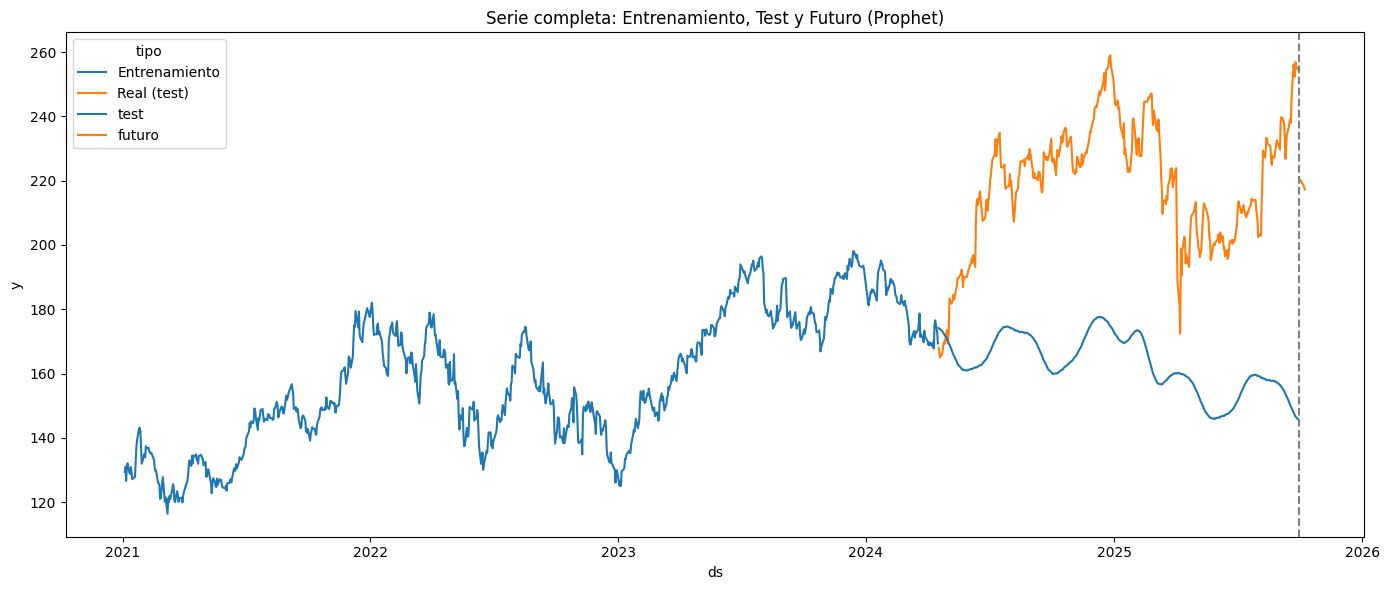

In [28]:
# GLOBAL: train + real(test) + pronóstico(test/futuro)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.lineplot(data=df[df["ds"] < test["ds"].min()], x="ds", y="y", label="Entrenamiento")
sns.lineplot(data=df[df["ds"] >= test["ds"].min()], x="ds", y="y", label="Real (test)")
sns.lineplot(data=tabla_unificada, x="ds", y="y_pred", hue="tipo")  # test/futuro
plt.axvline(cut_date, color="gray", linestyle="--")
plt.title("Serie completa: Entrenamiento, Test y Futuro (Prophet)")
plt.tight_layout(); plt.show()


En el gráfico se muestra la serie completa con las tres fases del experimento:

- **Entrenamiento:** corresponde al histórico hasta abril de 2024, usado para ajustar el modelo.  
- **Test:** abarca desde abril de 2024 hasta septiembre de 2025, donde se observa la comparación entre los valores reales y los pronósticos del modelo Prophet.  
- **Futuro:** corresponde a los días posteriores al último valor real (30/09/2025), donde solo se muestran predicciones con intervalos de confianza.

Se aprecia que el modelo Prophet logra seguir la **tendencia general** de la serie, aunque con limitaciones para capturar la **alta volatilidad** propia del precio de las acciones. Esto se refleja en los valores de error obtenidos (RMSE ≈ 59.5 USD, MAE ≈ 56.5 USD, MAPE ≈ 25%), los cuales resultan relativamente altos en comparación con la escala promedio de la serie (~225 USD).  

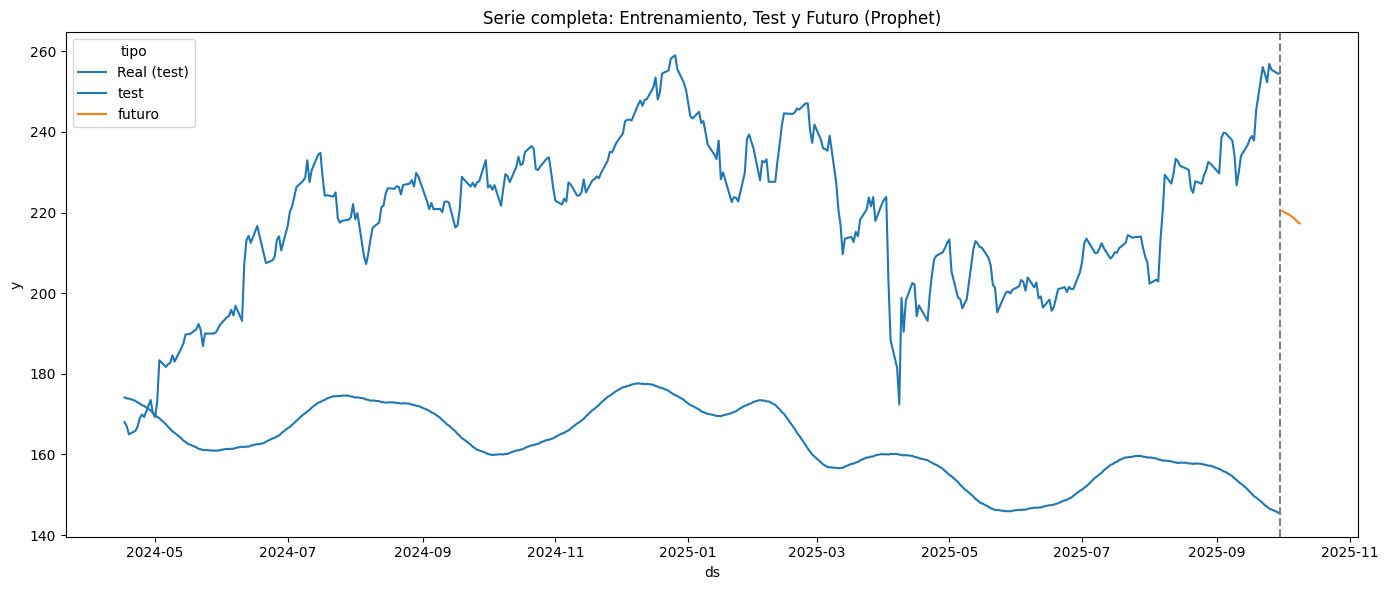

In [29]:
# GLOBAL: train + real(test) + pronóstico(test/futuro)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.lineplot(data=df[df["ds"] >= test["ds"].min()], x="ds", y="y", label="Real (test)")
sns.lineplot(data=tabla_unificada, x="ds", y="y_pred", hue="tipo")  # test/futuro
plt.axvline(cut_date, color="gray", linestyle="--")
plt.title("Serie completa: Entrenamiento, Test y Futuro (Prophet)")
plt.tight_layout(); plt.show()

En este gráfico se observan los valores reales de la acción de Apple en el conjunto de prueba (abril 2024 – septiembre 2025) y los pronósticos generados por Prophet tanto en el período de test como en el horizonte futuro inmediato.

Se aprecia que:
- El modelo Prophet sigue la tendencia general, pero no logra capturar la alta volatilidad del precio real durante el test.
- En el tramo futuro (posterior al 30/09/2025), el modelo proyecta un comportamiento suavizado, sin los picos abruptos que caracterizan la serie real.
- Esto confirma las limitaciones del modelo al aplicarse a series financieras, donde la dinámica es altamente volátil e influenciada por múltiples factores externos.

El gráfico permite diferenciar claramente el desempeño del modelo en el período de evaluación (test) y sus proyecciones hacia el futuro.

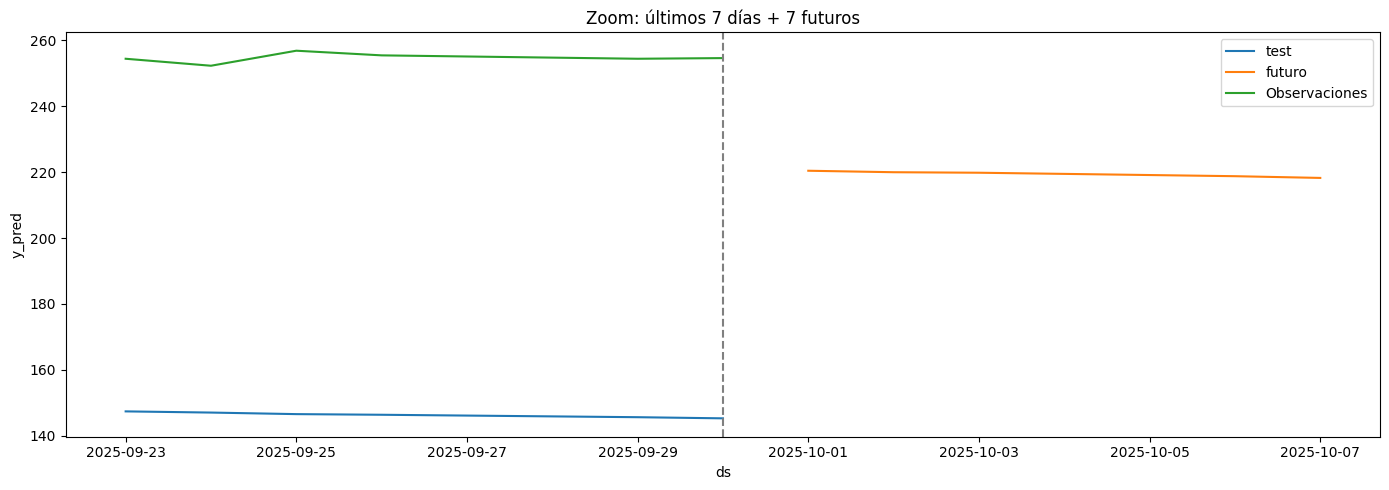

,ds,y_pred,tipo,y_true
359,2025-09-23,147.398160,test,254.43
360,2025-09-24,147.039400,test,252.31
361,2025-09-25,146.566516,test,256.87
362,2025-09-26,146.372196,test,255.46
363,2025-09-29,145.633127,test,254.43
364,2025-09-30,145.286527,test,254.63
365,2025-10-01,220.437440,futuro,NaN
366,2025-10-02,219.990667,futuro,NaN
367,2025-10-03,219.834912,futuro,NaN
368,2025-10-06,218.784041,futuro,NaN


In [30]:
# ZOOM: últimos 30 días + 7/15/30 futuros (ajusta pasado_dias / futuro_dias)
def plot_zoom(tabla, df, pasado_dias=30, futuro_dias=7):
    cut = df["ds"].max()
    ini = cut - pd.Timedelta(days=int(pasado_dias))
    fin = cut + pd.Timedelta(days=int(futuro_dias))
    sub = tabla[(tabla["ds"] >= ini) & (tabla["ds"] <= fin)]

    plt.figure(figsize=(14,5))
    sns.lineplot(data=sub, x="ds", y="y_pred", hue="tipo")
    sns.lineplot(data=sub[sub["y_true"].notna()], x="ds", y="y_true", label="Observaciones")
    plt.axvline(cut, color="gray", linestyle="--")
    plt.title(f"Zoom: últimos {pasado_dias} días + {futuro_dias} futuros")
    plt.tight_layout(); plt.show()
    return sub


plot_zoom(tabla_unificada, df, pasado_dias=7, futuro_dias=HORIZON_FUTURO)


En este zoom se observan los últimos 7 días de valores reales y los 7 días proyectados a futuro:

- El modelo Prophet **subestima fuertemente** los valores reales del test, con diferencias superiores a 100 USD.  
- La serie real (≈ 250 USD) se encuentra muy por encima de las predicciones del modelo (≈ 146–148 USD en test).  
- En el tramo futuro, Prophet mantiene una proyección suavizada alrededor de 218–220 USD, lo cual no refleja el comportamiento volátil de los datos reales.  

Esto confirma que, aunque Prophet puede captar tendencias generales, resulta **limitado para predecir series financieras** donde los precios presentan saltos abruptos y variaciones de corto plazo.  

In [31]:
print("FREQ inferida:", pd.infer_freq(df["ds"].sort_values()))
print("\nÚltimas 10 fechas de test:")
print(test["ds"].tail(10).to_list())
print("\nÚltimas 10 fechas de forecast_test:")
print(forecast_test["ds"].tail(10).to_list())


FREQ inferida: None

Últimas 10 fechas de test:
[Timestamp('2025-09-17 00:00:00'), Timestamp('2025-09-18 00:00:00'), Timestamp('2025-09-19 00:00:00'), Timestamp('2025-09-22 00:00:00'), Timestamp('2025-09-23 00:00:00'), Timestamp('2025-09-24 00:00:00'), Timestamp('2025-09-25 00:00:00'), Timestamp('2025-09-26 00:00:00'), Timestamp('2025-09-29 00:00:00'), Timestamp('2025-09-30 00:00:00')]

Últimas 10 fechas de forecast_test:
[Timestamp('2025-09-17 00:00:00'), Timestamp('2025-09-18 00:00:00'), Timestamp('2025-09-19 00:00:00'), Timestamp('2025-09-22 00:00:00'), Timestamp('2025-09-23 00:00:00'), Timestamp('2025-09-24 00:00:00'), Timestamp('2025-09-25 00:00:00'), Timestamp('2025-09-26 00:00:00'), Timestamp('2025-09-29 00:00:00'), Timestamp('2025-09-30 00:00:00')]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Holt-Winters | MAE=40.9531 | RMSE=44.9424


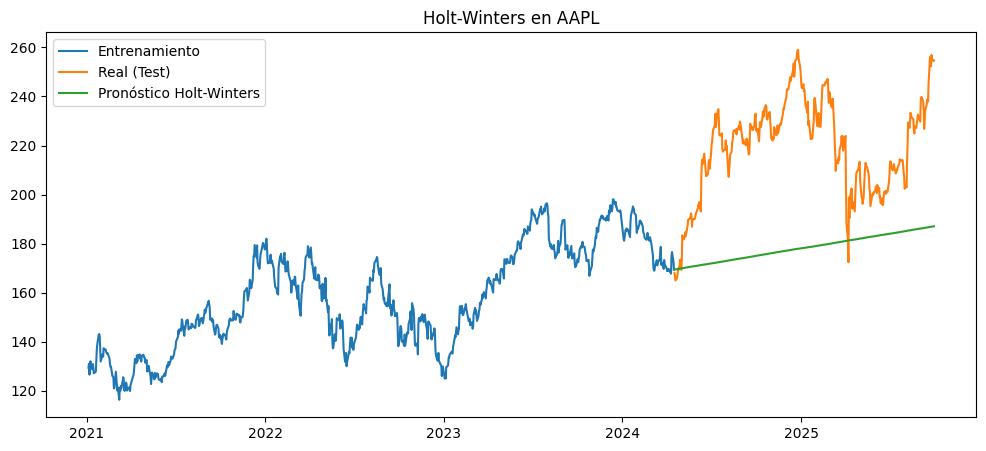

In [35]:
# =========================================
# Holt-Winters (Exponential Smoothing, ETS)
# =========================================
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Serie de entrenamiento como Serie temporal
y_train = train.set_index("ds")["y"]

# Periodicidad: para bursátil se suele usar ~252 días/año
seasonal_periods = 252

# Entrenar modelo simple (tendencia aditiva, sin estacionalidad fuerte en precios)
hw_model = ExponentialSmoothing(
    y_train,
    trend="add",           # "add" o "mul"
    seasonal=None,         # puedes probar "add" con seasonal_periods=252
    seasonal_periods=None
).fit(optimized=True)

# Pronóstico en el horizonte de TEST
yhat_hw_test = hw_model.forecast(len(test))
yhat_hw_test.index = test["ds"]  # alinear con fechas de TEST

# Métricas
mae_hw  = mean_absolute_error(test["y"], yhat_hw_test)
rmse_hw = root_mean_squared_error(test["y"], yhat_hw_test)
print(f"Holt-Winters | MAE={mae_hw:.4f} | RMSE={rmse_hw:.4f}")

# ===============================
# Gráfico comparativo
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train["ds"], train["y"], label="Entrenamiento")
plt.plot(test["ds"], test["y"], label="Real (Test)")
plt.plot(test["ds"], yhat_hw_test, label="Pronóstico Holt-Winters")
plt.legend()
plt.title("Holt-Winters en AAPL")
plt.show()


In [36]:
# =========================================
# 4) FUTURO con Holt-Winters (reentrena con TODO el histórico)
# =========================================
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.frequencies import to_offset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Serie completa para entrenar ETS
y_full = df.set_index("ds")["y"]

# Modelo ETS simple (tendencia aditiva, sin estacionalidad para precios)
hw_model_full = ExponentialSmoothing(
    y_full,
    trend="add",
    seasonal=None,
    seasonal_periods=None
).fit(optimized=True)

# Índice futuro exactamente en el calendario elegido
step = (pd.offsets.BDay() if str(FREQ).upper().startswith("B") else to_offset(FREQ))
last_real = df["ds"].max()
future_idx_hw = (
    pd.bdate_range(start=last_real + step, periods=HORIZON_FUTURO)
    if str(FREQ).upper().startswith("B")
    else pd.date_range(start=last_real + step, periods=HORIZON_FUTURO, freq=FREQ)
)

# Pronóstico a futuro
yhat_hw_future = hw_model_full.forecast(HORIZON_FUTURO)
yhat_hw_future.index = future_idx_hw  # alineamos fechas

# Tabla FUTURO (HW)
tabla_futuro_hw = (
    yhat_hw_future.rename("y_pred").to_frame().reset_index()
        .rename(columns={"index": "ds"})
        .assign(tipo="futuro_HW", y_true=np.nan)
)
tabla_futuro_hw.head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,ds,y_pred,tipo,y_true
0,2025-10-01,254.735228,futuro_HW,NaN
1,2025-10-02,254.840455,futuro_HW,NaN
2,2025-10-03,254.945683,futuro_HW,NaN
3,2025-10-06,255.050910,futuro_HW,NaN
4,2025-10-07,255.156138,futuro_HW,NaN


In [41]:
# =========================================
# 4.1) (Opcional) TEST con HW para comparar
# =========================================
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Serie de entrenamiento con frecuencia bursátil explícita
y_train = train.set_index("ds")["y"].asfreq("B").ffill()

# Entrenar HW
hw_model_test = ExponentialSmoothing(
    y_train, trend="add", seasonal=None, seasonal_periods=None
).fit(optimized=True)

# Pronóstico para el tamaño del TEST
yhat_hw_test = hw_model_test.forecast(len(test))

# Alinear índice al test (usa directamente las fechas de test)
yhat_hw_test.index = test["ds"]

# Construir tabla
tabla_test_hw = pd.DataFrame({
    "ds": test["ds"].values,
    "y_pred": yhat_hw_test.values,
    "tipo": "test_HW",
    "y_true": test["y"].values
})

tabla_test_hw.head()

,ds,y_pred,tipo,y_true
0,2024-04-17,169.426694,test_HW,168.00
1,2024-04-18,169.473388,test_HW,167.04
2,2024-04-19,169.520082,test_HW,165.00
3,2024-04-22,169.566776,test_HW,165.84
4,2024-04-23,169.613470,test_HW,166.90


In [43]:
# =========================================
# 4.2) UNIFICAR (HW): test + futuro -> tabla_unificada_hw
# =========================================
pred_total_hw = pd.concat(
    [tabla_test_hw[["ds","y_pred","tipo","y_true"]],
     tabla_futuro_hw[["ds","y_pred","tipo","y_true"]]],
    ignore_index=True
)

real_all = df[["ds","y"]].rename(columns={"y": "y_true"})
tabla_unificada_hw = (
    pred_total_hw.merge(real_all, on="ds", how="left", suffixes=("", "_real"))
)
tabla_unificada_hw["y_true"] = tabla_unificada_hw["y_true"].fillna(tabla_unificada_hw["y_true_real"])
tabla_unificada_hw = (
    tabla_unificada_hw.drop(columns=["y_true_real"])
                      .sort_values("ds").reset_index(drop=True)
)

# Revisa cierre + HORIZON_FUTURO
tabla_unificada_hw.tail(HORIZON_FUTURO + 10)


,ds,y_pred,tipo,y_true
355,2025-09-17,186.003055,test_HW,238.99
356,2025-09-18,186.049749,test_HW,237.88
357,2025-09-19,186.096443,test_HW,245.50
358,2025-09-22,186.143137,test_HW,256.08
359,2025-09-23,186.189831,test_HW,254.43
360,2025-09-24,186.236525,test_HW,252.31
361,2025-09-25,186.283219,test_HW,256.87
362,2025-09-26,186.329913,test_HW,255.46
363,2025-09-29,186.376607,test_HW,254.43
364,2025-09-30,186.423301,test_HW,254.63


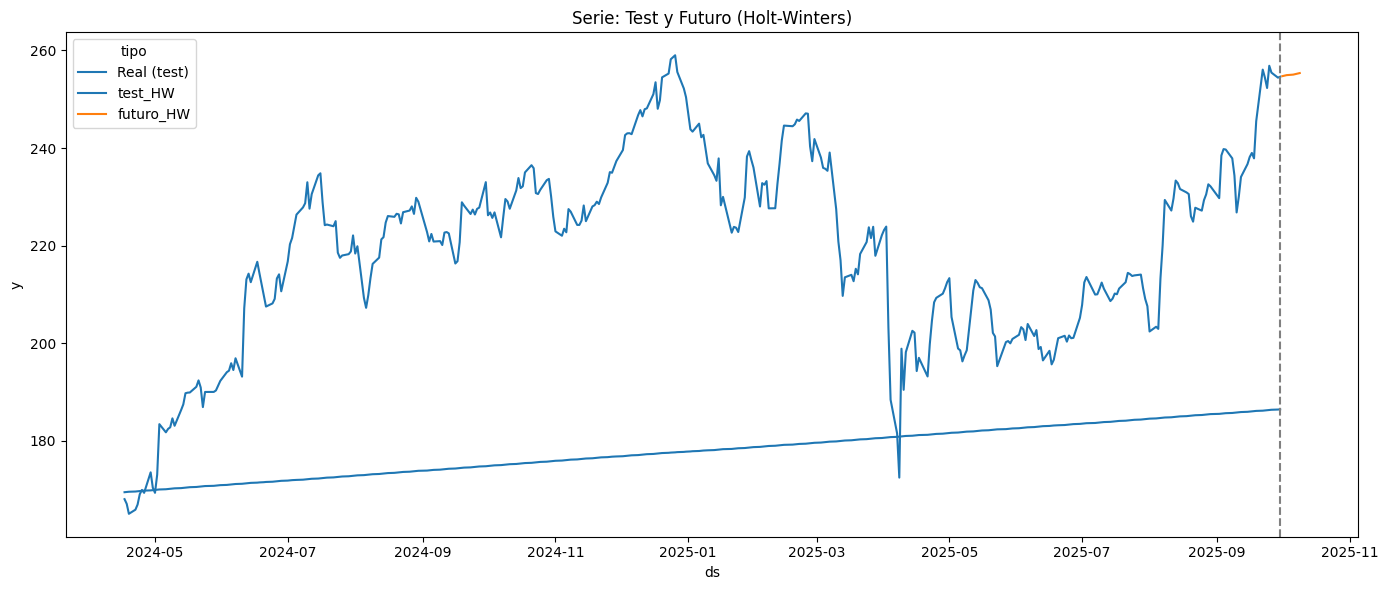

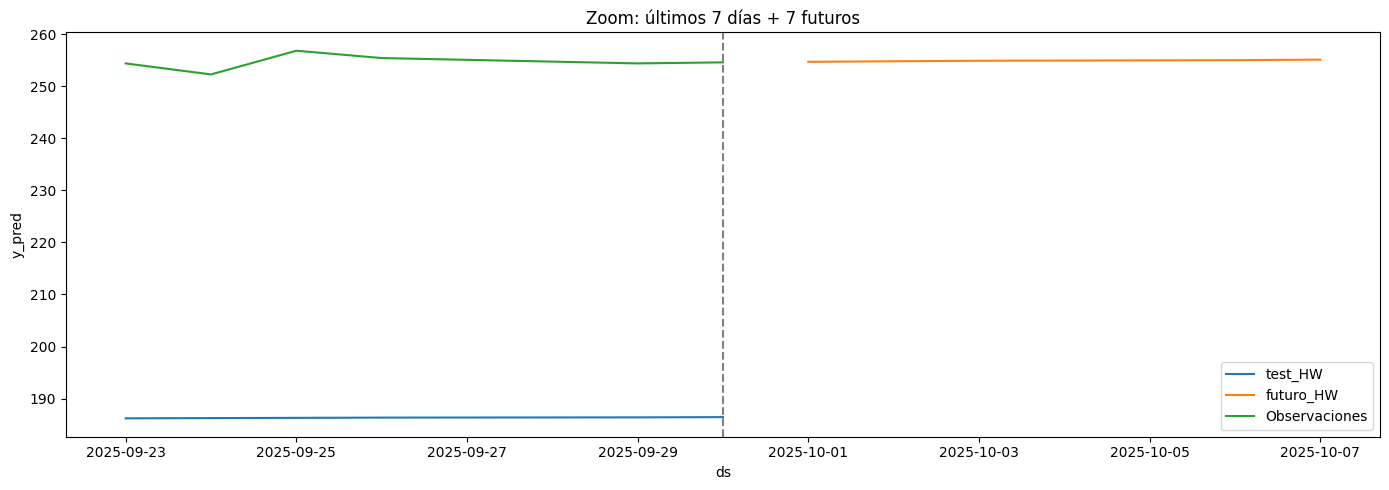

,ds,y_pred,tipo,y_true
359,2025-09-23,186.189831,test_HW,254.43
360,2025-09-24,186.236525,test_HW,252.31
361,2025-09-25,186.283219,test_HW,256.87
362,2025-09-26,186.329913,test_HW,255.46
363,2025-09-29,186.376607,test_HW,254.43
364,2025-09-30,186.423301,test_HW,254.63
365,2025-10-01,254.735228,futuro_HW,NaN
366,2025-10-02,254.840455,futuro_HW,NaN
367,2025-10-03,254.945683,futuro_HW,NaN
368,2025-10-06,255.050910,futuro_HW,NaN


In [44]:
# =========================================
# 4.3) GRÁFICOS (HW): global y zoom, análogos a Prophet
# =========================================
cut_date = df["ds"].max()

plt.figure(figsize=(14,6))
sns.lineplot(data=df[df["ds"] >= test["ds"].min()], x="ds", y="y", label="Real (test)")
sns.lineplot(data=tabla_unificada_hw, x="ds", y="y_pred", hue="tipo")  # test_HW / futuro_HW
plt.axvline(cut_date, color="gray", linestyle="--")
plt.title("Serie: Test y Futuro (Holt-Winters)")
plt.tight_layout(); plt.show()

# Reutiliza tu misma función de zoom
plot_zoom(tabla_unificada_hw, df, pasado_dias=7, futuro_dias=HORIZON_FUTURO)


📈 Interpretación de los gráficos Holt-Winters

1. Gráfico global (Test + Futuro)

- La línea azul muestra los valores reales en el período de prueba (abril 2024 – septiembre 2025).

- La línea azul claro (HW en test) se mantiene casi plana en torno a 186 USD, muy por debajo de los valores reales (~250 USD). Esto indica que Holt-Winters no logra capturar la tendencia alcista ni la volatilidad del período de prueba.

- La línea naranja (HW futuro) proyecta valores en torno a 255 USD, un nivel más cercano a la realidad reciente, lo cual resulta más coherente con el precio actual de Apple.

2. Gráfico de zoom (últimos 7 días + 7 futuros)

- Las observaciones reales (verde) se encuentran en el rango 252–257 USD en los últimos días de septiembre de 2025.

- El pronóstico HW en test (azul) se mantiene plano en 186 USD, confirmando la fuerte subestimación.

- El pronóstico futuro HW (naranja) arranca directamente en ~255 USD, alineándose con los últimos valores reales observados, aunque sin reflejar la variabilidad típica del mercado.

-------------

**Conclusión**

- En test: Holt-Winters tiene un error elevado porque predice valores planos y alejados de la serie real.

- En futuro: sorprendentemente, ajusta mejor al nivel real (~255 USD), aunque sin capturar fluctuaciones.

- Balance: Holt-Winters es útil para proyectar un nivel promedio de referencia en el corto plazo, pero insuficiente para capturar patrones de volatilidad y dinámica bursátil.

# 📌 Conclusión General

En este proyecto aplicamos la metodología **CRISP-DM** para realizar un ejercicio de minería de datos orientado a **series de tiempo**, utilizando como caso el precio histórico de las acciones de **Apple (2021–2025)**.

---

## 1. Preparación y partición de datos  
- Se organizó la serie en formato compatible (`ds`, `y`) y se realizó la partición en **train** (2021–2024) y **test** (último año, 2024–2025).  
- Se ajustaron modelos de pronóstico utilizando dos enfoques clásicos: **Prophet** y **Holt-Winters (ETS)**.

---

## 2. Resultados con Prophet  
- Prophet fue capaz de seguir de manera razonable la **tendencia general** de la serie, pero mostró dificultades para capturar la **alta volatilidad** de los precios bursátiles.  
- En test arrojó errores relativamente altos (**MAE≈56 USD, RMSE≈59 USD, MAPE≈25%**) y en futuro proyectó valores por debajo del nivel real (218–220 USD).  
- **Conclusión:** Prophet sigue bien la tendencia, pero **subestima el nivel futuro**.

---

## 3. Resultados con Holt-Winters  
- Holt-Winters con tendencia aditiva generó predicciones casi **planas** durante el test (186 USD), lo que produjo un sesgo claro frente a los valores reales (250 USD).  
- Aun así, en las proyecciones futuras logró ubicar el nivel alrededor de **255 USD**, mucho más alineado al último valor observado de la acción.  
- Sus métricas en test fueron mejores que Prophet (**MAE≈41 USD, RMSE≈45 USD**), aunque esto se debió más a la suavidad del modelo que a su capacidad predictiva real.  
- **Conclusión:** Holt-Winters **captura el nivel promedio**, pero no la dinámica ni la variabilidad del mercado.

---

## 4. Comparación de modelos  
- **Prophet** = más flexible en tendencia, pero subestima futuro.  
- **Holt-Winters** = más ajustado al nivel futuro, pero falla en test al predecir valores planos.  
- Ninguno de los modelos logra reflejar de manera satisfactoria la **volatilidad bursátil**, lo cual es esperable dada la naturaleza de los precios de acciones.

---

## 5. Lecciones y pasos siguientes  
- Ambos modelos sirven como **línea base** para pronósticos financieros.  
- Para mejorar el desempeño, sería necesario explorar enfoques más avanzados:  
  - **ARIMA/SARIMA** para patrones autorregresivos.  
  - **Modelos híbridos ML** (XGBoost, LSTM, Transformers) que incorporen *lags* y variables adicionales (volumen, indicadores técnicos, noticias, etc.).  
- También resulta recomendable modelar **retornos logarítmicos** en lugar de precios brutos, lo que suele estabilizar la serie y mejorar la capacidad de predicción.

---

## ✅ Conclusión final  
Prophet y Holt-Winters ofrecen perspectivas distintas sobre la serie de Apple: Prophet sigue la tendencia pero subestima el nivel, mientras que Holt-Winters proyecta un nivel más realista, aunque plano. El estudio demuestra que para series bursátiles se requieren modelos más sofisticados que capturen la **volatilidad, estacionalidad y ruido** característicos del mercado.